# ChordGAN

ChordGAN importing the models from a py file

In [1]:
# Initial setup to be able to load `src.preprocess`
import os
import sys

top_dir = os.path.split(os.getcwd())[0]
sys.path.append(top_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import tensorflow as tf
from tensorflow import keras

from src.preprocess import load_data

%load_ext lab_black
%load_ext tensorboard

# python script, in github repo
print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Numpy version:", np.__version__)

TF version: 2.6.0
Keras version: 2.6.0
Numpy version: 1.21.2


## Load data

In [3]:
fpath = os.path.join(top_dir, "../data/ChordGAN")
genre = "pop"

dataset, (songs, names) = load_data(fpath, genre=genre, shuffle=False)

c:\Users\gamin\anaconda3\envs\chordgan\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Creating TF dataset from the loaded songs
Creating TF dataset from the loaded songs
Complete.


In [4]:
sample_songs = []
sample_chromas = []

for s, c in dataset.take(10):
    sample_songs.append(s.numpy())
    sample_chromas.append(c.numpy())

Let's peek at the chromas

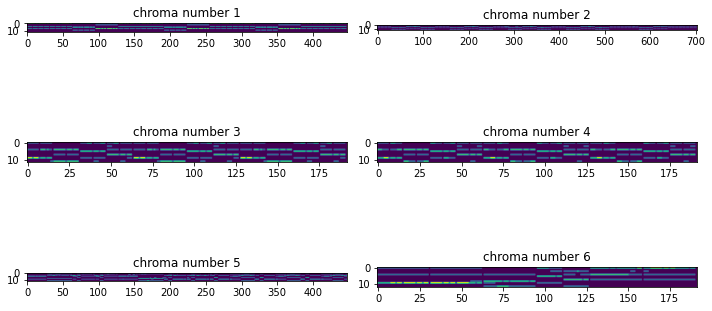

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, (chroma, ax) in enumerate(zip(sample_chromas[:10], axes.flatten())):
    ax.set_title(f"chroma number {i+1}")
    ax.imshow(chroma[:48].T, cmap="viridis")
plt.tight_layout()
plt.show()

And at the songs

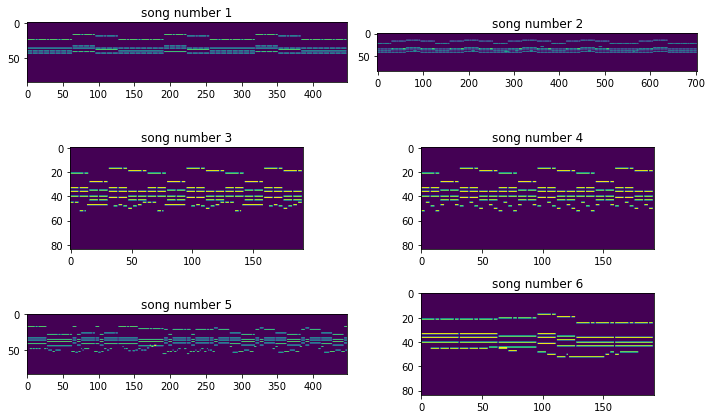

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, (song, ax) in enumerate(zip(sample_songs[:10], axes.flatten())):
    ax.set_title(f"song number {i+1}")
    ax.imshow(song[:128].T, cmap="viridis")
plt.tight_layout()
plt.show()

## Setup GAN model

Note:

The discriminator has both the song timeseries and the chromagram as inputs, hence the two-dimensional inputs!

In [7]:
from src.model import ChordGAN

cgan = ChordGAN()
cgan.compile(tf.keras.optimizers.Adam(lr=1e-5), tf.keras.optimizers.Adam(lr=1e-4))

c:\Users\gamin\anaconda3\envs\chordgan\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test the generator

(1, 448, 84)


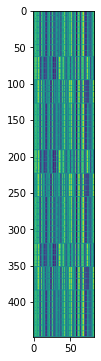

In [8]:
sample_chroma = sample_chromas[0]
sample_out = cgan.generator(sample_chroma)

print(sample_out.shape)
plt.figure(figsize=(8, 6))
plt.imshow(sample_out[0])
plt.show()

Test the discriminator

In [10]:
sample_song = sample_songs[0]
sample_logits, sample_probas = cgan.discriminator((sample_song, sample_chroma))
print(
    f"Probability this is a true song, not a generated song: {tf.reduce_mean(sample_probas).numpy():.2%} "
)

Probability this is a true song, not a generated song: 48.74% 


# Training

In [11]:
n_epochs = 5_000
cgan.fit(dataset, batch_size=4, epochs=n_epochs)

Epoch 1/5000
122/122 [==============================] - 3s 14ms/step - d_loss: 1.6542 - g_loss: 25.1615
Epoch 2/5000
122/122 [==============================] - 2s 14ms/step - d_loss: 1.3848 - g_loss: 17.4497
Epoch 3/5000
122/122 [==============================] - 2s 16ms/step - d_loss: 1.2874 - g_loss: 12.1157
Epoch 4/5000
122/122 [==============================] - 2s 18ms/step - d_loss: 1.2502 - g_loss: 8.7326
Epoch 5/5000
122/122 [==============================] - 2s 18ms/step - d_loss: 1.2355 - g_loss: 6.7189
Epoch 6/5000
122/122 [==============================] - 2s 19ms/step - d_loss: 1.2309 - g_loss: 5.5265
Epoch 7/5000
122/122 [==============================] - 2s 19ms/step - d_loss: 1.2314 - g_loss: 4.7641
Epoch 8/5000
122/122 [==============================] - 2s 16ms/step - d_loss: 1.2339 - g_loss: 4.2269
Epoch 9/5000
122/122 [==============================] - 2s 15ms/step - d_loss: 1.2374 - g_loss: 3.8212
Epoch 10/5000
122/122 [==============================] - 2s 16ms/step 

We can access the losses via `history.history`

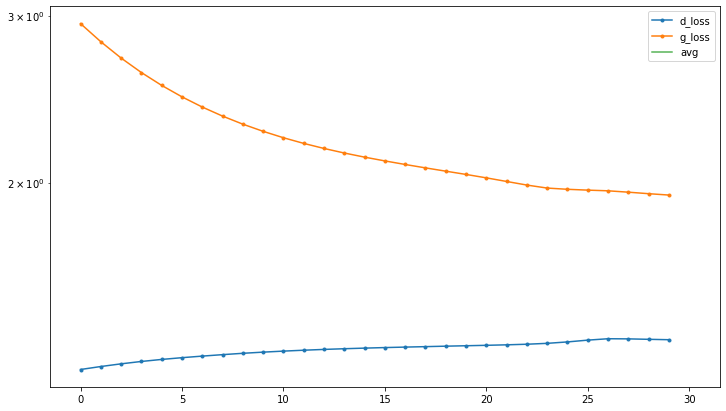

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


hist = cgan.history.history

n = 30
avg = moving_average(hist["g_loss"], n)

plt.figure(figsize=(12, 7))
plt.plot(range(len(hist["d_loss"])), hist["d_loss"], ".-", label="d_loss")
plt.plot(range(len(hist["g_loss"])), hist["g_loss"], ".-", label="g_loss")
plt.plot(range(n, len(avg) + n), avg, "-", label="avg", alpha=0.8)
plt.legend()
plt.yscale("log")
plt.show()

#### TODO:
Now that i'm able to train the model, I need to implement the `call` method, that will convert the songs, if the model is trained.

In [ ]:
cgan.save_weights(f"../trained_models/weights/new_prep/{genre}/{n_epochs}e")

Naturally it doesn't make sense to look at this as an image but it at least shows the result is close enough

# Style Transfer

In [16]:
import reverse_pianoroll
import convert
from src.model import ChordGAN

new_cgan = ChordGAN()
new_cgan.load_weights(f"trained_models/weights/new_prep/{genre}/{n_epochs}e")

Load data for transfer

In [18]:
transfer_genre = "jazz"
new_ds, (songs, names) = load_data(fpath, "jazz", shuffle=False)

Creating TF dataset from the loaded songs
Creating TF dataset from the loaded songs
Complete.


TODO: Figure out a way of outputting the original song along with the transferred one

In [38]:
import os
import reverse_pianoroll


dir_name = f"../converted_songs/new_prep/{genre}2{transfer_genre}_{n_epochs}e"
os.makedirs(dir_name, exist_ok=True)

for idx, ((_, chroma), song, name) in enumerate(zip(new_ds, songs, names)):
    name = os.path.split(name)[-1].split(".")[0]
    # song_midi = reverse_pianoroll.piano_roll_to_pretty_midi(song)
    transfer = new_cgan(chroma)
    transfer.write(f"{dir_name}/{name}_{idx}_transfer.midi")
    # song_midi.write(f"{dir_name}/{name}_{idx}_original.midi")
    break

In [36]:
transfer.get_piano_roll().shape

(128, 19600)